# **Multi-Label Video Classification** <a class="tocSkip"></a>

## A TensorFlow 2.0 Journey, and More! <a class="tocSkip"></a>

*Kyle Chung*

*2019-07-22 04:40:50 Last Updated*

------

This is a project I've done in the open project week during my training on Goole's Advanced Solutions Labs at Singapore site.
The dataset used is [YouTue-8M](https://research.google.com/youtube8m/): a public dataset created by Google Research.
It contains pre-processed video features in [TensorFlow TFRecord](https://www.tensorflow.org/tutorials/load_data/tf_records) format.

These are the stuff I've done during the week:

1. Use [TensorFlow](https://github.com/tensorflow/tensorflow) to build a baseline model for youtube video label prediction
2. Deploy the model onto Google Cloud [AI Platform](https://cloud.google.com/ai-platform/) as a prediction service
3. Create an asynchronous web appilication that user can input a youtube video share link and get the predicted labels

This notebook is a final wrap-up of the project, with some additional follow-up improvement.
It can also serve as a reference point for my experience on TensorFlow 2.0, which is still in its beta stage as write-up of this notebook.

In [1]:
import logging

import numpy as np
import tensorflow as tf

logging.getLogger("tensorflow").setLevel(logging.ERROR)

#  Configure array print width.
np.set_printoptions(edgeitems=2)
np.core.arrayprint._line_width = 160

print(tf.__version__)

2.0.0-beta1


## Deal with TFRecords

TFRecords are an efficient way of storing data and performing batch training in TensorFlow modeling.
The advatnage is that it can handle virtually any data type, not limited to a tabular representation.
Of course it comes at a cost: We do need some extra engineering effort to handle data in tfrecord format.

In this section we'll talk about how to read, create, and process data in tfrecord format.

In [2]:
%%bash
# List some files from youtube-8m video-level training data.
ls -d -l data/video/*  | grep "train.*tfrecord$" | head -n3

-rw-rw-rw- 1 kylechung kylechung 4819410 Jul 20 07:41 data/video/train0000.tfrecord
-rw-rw-rw- 1 kylechung kylechung 4729969 Jul 20 06:49 data/video/train0001.tfrecord
-rw-rw-rw- 1 kylechung kylechung 4763009 Jul 20 07:54 data/video/train0002.tfrecord


In [3]:
tfrec_file = "data/video/train0001.tfrecord"

### Inspection of TFRecords

To inspect a given tfrecord without any schema, it is best to take a single example and print its content in plain text.
Since all kinds of features are serialized to byte strings in tfrecord, the inspection is agnostic to the original feature format.
In TF 2.0 the data handling framework has been unified to the `tf.data` API.

In [4]:
# Create a dataset iterator of tfrecords.
rec_iter = tf.data.TFRecordDataset(tfrec_file)

# Take just one example.
# The return object is a Tensor of a single byte string.
rec_ex = next(rec_iter.__iter__())

# To parse it we'd like to get rid of the Tensor wrapping,
# leaving the byte string alone.
rec_ex = rec_ex.numpy()
example = tf.train.Example()  # For sequence examples use tf.train.SequenceExample.
example.ParseFromString(rec_ex)

# The parsed result will be a human-readable protobuf.
print(str(example)[:500])  # Truncated to print less.

features {
  feature {
    key: "id"
    value {
      bytes_list {
        value: "2vab"
      }
    }
  }
  feature {
    key: "labels"
    value {
      int64_list {
        value: 14
      }
    }
  }
  feature {
    key: "mean_audio"
    value {
      float_list {
        value: 0.4810151159763336
        value: -0.1483372300863266
        value: -0.6934748888015747
        value: 1.2363330125808716
        value: 0.53005450963974
        value: 1.1766775846481323
        value: -1.10115957


### Parse TFRecords with Schema

To really make use of data stored in tfrecords, we need to specify a schema to parse the underlying protobuf.
We use `tf.io.FixedLenFeature` and `tf.io.VarLenFeature` to specify the nature of the features to be parsed, including its length, type, and dimension.

In [5]:
# Specify feature spec.
video_feature_spec = {
    "id": tf.io.FixedLenFeature([], tf.string),
    "labels": tf.io.VarLenFeature(tf.int64),
    "mean_rgb": tf.io.FixedLenFeature((1024,), tf.float32),
    "mean_audio": tf.io.FixedLenFeature((128,), tf.float32)
}

# Take another example in the tfrecords.
rec_ex = next(rec_iter.__iter__())

# Parse with feature spec.
# To parse multiple examples as a batch, use tf.io.parse_example instead.
parsed_example = tf.io.parse_single_example(rec_ex, features=video_feature_spec)

# The result is a dict of feature Tensors.
tf.print(parsed_example)

{'id': "2vab",
 'labels': 'SparseTensor(indices=[[0]], values=[14], shape=[1])',
 'mean_audio': [0.481015116 -0.14833723 -0.693474889 ... 0.0226273146 0.0394227207 0.36170435],
 'mean_rgb': [0.388561159 -1.41187453 -0.171391308 ... 0.157069772 -0.233502612 -0.605695128]}


### Making Input Function for Modeling

For training using custom `tf.estimator.Estimator` we need a so-called input function to handle the data pipeline.
An input function takes the source files, convert records into `tf.data.Dataset` and apply necessary transofrmation.
Conventionally the resulting dataset will return a tuple of features and labels, where the features are warpped in a dict of tensors and labels are purely a tensor.

This time we will use [Feature Column](https://www.tensorflow.org/guide/feature_columns) to define our features, the corresponding feature spec can be derived from feature columns.

One special treatment is required to encode the label tensor.
Since the task is a multi-label classification, meaning that each example can have more than one correct labels, we need to transform the label tensor into a dense multi-hot encoding representation in order to perform loss calculation.

In [6]:
from tensorflow import feature_column as fc

# Define feature columns.
# We will ignore the id column since we don't need it.
# Also we drop the audio feature for now.
feat_col_video = [
    fc.numeric_column(key="mean_rgb", shape=(1024,), dtype=tf.float32),
    fc.numeric_column(key="mean_audio", shape=(128,), dtype=tf.float32),
    fc.indicator_column(fc.categorical_column_with_identity(
        key="labels", num_buckets=3862))
]

# Derive feature spec from feature columns.
feat_spec_video = fc.make_parse_example_spec(feat_col_video)
tf.print(feat_spec_video)

{'labels': VarLenFeature(dtype=tf.int64),
 'mean_audio': FixedLenFeature(shape=(128,), dtype=tf.float32, default_value=None),
 'mean_rgb': FixedLenFeature(shape=(1024,), dtype=tf.float32, default_value=None)}


In [7]:
from functools import partial

multi_hot_encoder = tf.keras.layers.DenseFeatures(feat_col_video[-1])

def _parse(examples, spec, batch_size, n_class, multi_hot_y):
    features = tf.io.parse_example(examples, features=spec)
    labels = features.pop("labels")
    if multi_hot_y:
        labels = multi_hot_encoder({"labels": labels})
    return features, labels

def input_fn(infiles, spec, batch_size, n_class, multi_hot_y=True, mode=tf.estimator.ModeKeys.TRAIN):
    dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(infiles))
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=1000).repeat(count=None)
        dataset = dataset.batch(batch_size, drop_remainder=True)
    else:
        dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.map(partial(_parse, spec=spec, batch_size=batch_size,
                                  n_class=n_class, multi_hot_y=multi_hot_y))
    dataset = dataset.prefetch(batch_size)
    return dataset

In [8]:
# Test the input function.
train_files = "data/video/train*"
dataset = input_fn(train_files, spec=feat_spec_video, batch_size=32, n_class=3862)

# Dataset is iterable.
for x, y in dataset:
    print("======Feature Dict======")
    print(x)
    print("======Label Tensor:======")
    print(y)
    break

======Feature Dict======
{'mean_audio': <tf.Tensor: id=146, shape=(32, 128), dtype=float32, numpy=
array([[-1.360545  , -0.71442294, ...,  0.45849124,  0.695119  ],
       [ 0.6953419 , -0.37989992, ...,  0.11259682, -0.9513509 ],
       ...,
       [ 0.5794203 ,  0.10077982, ..., -0.37566462, -0.18742932],
       [ 1.0512134 ,  1.9373561 , ..., -1.6345668 ,  0.24890658]],
      dtype=float32)>, 'mean_rgb': <tf.Tensor: id=147, shape=(32, 1024), dtype=float32, numpy=
array([[ 0.49278513,  0.37351862, ..., -0.21506596,  0.02092673],
       [ 1.2855642 , -1.721913  , ...,  0.7256164 , -0.53691953],
       ...,
       [-0.07312868, -1.0586973 , ..., -0.1454424 ,  0.1598125 ],
       [-0.37564442,  0.1038415 , ..., -0.28838128, -0.09355511]],
      dtype=float32)>}
======Label Tensor:======
tf.Tensor(
[[1. 1. ... 0. 0.]
 [0. 0. ... 0. 0.]
 ...
 [0. 0. ... 0. 0.]
 [0. 0. ... 0. 0.]], shape=(32, 3862), dtype=float32)


If we don't do multi-hot dense encoding, the resulting label tensor will be a sparse tensor recording the label indices with variable length.
We can print also its dense representation for a clear view:

In [9]:
dataset_test = input_fn(train_files, spec=feat_spec_video,
                        batch_size=32, n_class=3862, multi_hot_y=False)
for x_test, y_test in dataset_test:
    break

print(tf.sparse.to_dense(y_test)[:5])

tf.Tensor(
[[   2  522 1561    0    0    0    0    0]
 [   3    6    0    0    0    0    0    0]
 [  41    0    0    0    0    0    0    0]
 [   0   12    0    0    0    0    0    0]
 [   0   12    0    0    0    0    0    0]], shape=(5, 8), dtype=int64)


### Write TFRecords

In this project we don't really need to write TFRecords.
Since the only operation needed when doing model inference is covered by the starter code's feature extraction script.

For details about writing TFRecords one can refer to the [official document](https://www.tensorflow.org/tutorials/load_data/tf_records#write_the_tfrecord_file).

## Debug Network Layers

We will use `tf.keras.layers` API to construct our model.
Before we build the model, it is good to first observe how feature columns are parsed into network layers.
We can use `tf.keras.layers.DenseFeatures` to create a layer from a list of feature columns.
Essentially what it does is just to concatenate the vector to form a single tensor ready for connection to subsequent hidden layers.

### Feed Forward

In [10]:
# Specify feature columns that only contains features but not labels.
xname = ["mean_rgb", "mean_audio"]
feat_col_x = [col for col in feat_col_video if col.name in xname]

# Create a layer out of feature columns.
input_layer = tf.keras.layers.DenseFeatures(feat_col_x)

# Feed the layer with one batch of features.
print(input_layer(x))

tf.Tensor(
[[-1.360545   -0.71442294 ... -0.21506596  0.02092673]
 [ 0.6953419  -0.37989992 ...  0.7256164  -0.53691953]
 ...
 [ 0.5794203   0.10077982 ... -0.1454424   0.1598125 ]
 [ 1.0512134   1.9373561  ... -0.28838128 -0.09355511]], shape=(32, 1152), dtype=float32)


Let's create a final output layer to have number of neurons equal to number of classes, which is 3862 in this dataset.
And we feed the input layer derived from feature columns to this output layer to arrive the model output.

In [11]:
final_layer = tf.keras.layers.Dense(3862, activation="sigmoid")

# Feed-forward.
logits = input_layer(x)
output = final_layer(logits)

# The network output.
print(output)

tf.Tensor(
[[0.48733622 0.46331215 ... 0.46246886 0.5137628 ]
 [0.5214744  0.46407914 ... 0.40597236 0.40556628]
 ...
 [0.489693   0.5337485  ... 0.55123544 0.5208428 ]
 [0.39137942 0.44164637 ... 0.55346745 0.51629794]], shape=(32, 3862), dtype=float32)


To verify what's going on here, we can extract the initialized weights and biases from the final layer.
The output should be nothing more than just a sigmoid applying on a dot product of the input and final layer.
Sp if we manually implement the matrix operation, the result shoudl coincide with that of using `tf.keras.layers`.

In [12]:
# By default the bias is zero-initialized,
# so it won't affect our comparison before the model start to learn.
weights, biases = final_layer.get_weights()
output_check = tf.sigmoid(tf.matmul(logits, weights) + biases)
print(output_check)

tf.Tensor(
[[0.48733622 0.46331215 ... 0.46246886 0.5137628 ]
 [0.5214744  0.46407914 ... 0.40597236 0.40556628]
 ...
 [0.489693   0.5337485  ... 0.55123544 0.5208428 ]
 [0.39137942 0.44164637 ... 0.55346745 0.51629794]], shape=(32, 3862), dtype=float32)


### Loss

Now we have our output we can calculate the loss comparing to the label.
There are lots of high level API for loss calculation in the `tf.keras.losses` module.
Let's examine the API for binary cross entropy.

In [13]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
print(bce(y, output).numpy())

0.7081387


The cross entropy is defined as:

$$
\mbox{Cross Entropy Loss} = - \sum_{i=1}^N y_i\ln(q_i) + (1 - y_i)\ln(1 - q_i),
$$

where $q_i$ is the model predicted probability for the $i$-th example.

For multi-label case the API simply apply the calculation across both batch and label dimension.
That is, the summation is over both number of examples and number of labels.
To verify the result, we can manually code the calculation:

In [14]:
# This is not numerically stable but we don't mind for a quick dirty check.
z = y * tf.math.log(output) + (1 - y) * tf.math.log(1 - output)
print(tf.reduce_mean(-z).numpy())

0.70813894


The resulting number won't be exactly the same due to smoothing done by default in the API to avoid numerical instability.

We can also use a lower level API from the `tf.keras.backend` module to gain more control on how we'd like to aggregate individual losses.
For example, we may want to calculate instead the [Hamming Loss](https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics) which suits more for a multi-label scenario.
Essentially we are still calculating individual cross entropy, but will sum over the label dimension first, then do the averagging to arrive the final loss value.

In [15]:
# Retain batch_size x n_class dimension.
losses = tf.keras.backend.binary_crossentropy(y, output, from_logits=False)
hamming_loss = tf.reduce_mean(tf.reduce_sum(-z, axis=1))
print(hamming_loss.numpy())

2734.8325


### Evaluation Metrics

Evaluation metric is usually different from loss.
The former is used to guide the model in how weights should be updated, while the latter is the final criteria to judge the performance of a trained model. (Of course the ideal case is to align the two but for practical reason this is not always doable.)

The `tf.keras.metrics` module contains lots of built-in classifcal evaluation metrics at our disposal.
To calculate the metric given a batch:

In [16]:
# Use precision as an example.
# The result is really bad since we haven't started to train the model.
# All weights are just randomly initialized.
m = tf.keras.metrics.Precision()
m.update_state(y_true=y, y_pred=output)
m.result().numpy()

0.0009851262

## Build Models

For model not very complicated and customized, `tf.keras.models` API is a very fast way for prototyping.
We will simply connect the input layer to output layer, essentially build K-logistic regression model for K labels independently.
This is a classical baseline model for a multi-label learning task.

In [17]:
train_files = "data/video/train*"
valid_files = "data/video/valid*"

train_dataset = input_fn(train_files, spec=feat_spec_video,
                         batch_size=1024, n_class=3862)
valid_dataset = input_fn(valid_files, spec=feat_spec_video,
                         batch_size=1024, n_class=3862,
                         mode=tf.estimator.ModeKeys.EVAL)

l2_reg = tf.keras.regularizers.l2(1e-8)
model = tf.keras.models.Sequential(name="baseline")
model.add(tf.keras.layers.DenseFeatures(feat_col_x))
model.add(tf.keras.layers.Dense(3862, activation="sigmoid",
                                kernel_regularizer=l2_reg))
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)

To summarize the network architecture we can train a dummy step in order for the model to figure out the input dimension (since we don't bother define them in advance).

In [18]:
model.fit(dataset, epochs=1, steps_per_epoch=1, verbose=0)
model.summary()

Model: "baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features_2 (DenseFeatu multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  4452886   
Total params: 4,452,886
Trainable params: 4,452,886
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Test with more steps, also with validation.
model.fit(dataset, validation_data=valid_dataset, epochs=1,
          steps_per_epoch=100, validation_steps=10)

100/100 [==============================] - 2s 18ms/step - loss: 0.6682 - precision_1: 0.0012 - recall: 0.6144 - val_loss: 0.6327 - val_precision_1: 0.0016 - val_recall: 0.6531


### Use Tensorboard with Keras Model

To use `tensorboard` for keras model on tracking the model losses, we need to explicitly implement a callback function and pass it to the `fit` method.

In [20]:
%%bash
# Create directory to save pre-trained models.
mkdir -p models

In [21]:
tensorboard_callback = tf.keras.callbacks.TensorBoard()  # Default to ./logs.
model.fit(dataset, validation_data=valid_dataset, epochs=1,
          steps_per_epoch=100, validation_steps=10,
          callbacks=[tensorboard_callback],
          verbose=0)

Then we can run TensorBoard as usual:

```sh
tensorboard --logdir ./logs
```

### Custom Loss Function

We'd like to use Hamming Loss, optionally with class weight balancing since the labels are heavily skewed in this dataset.
The class weight to fully re-balance the training data distribution for class $i$ is defined as:

$$
\mbox{Class Weight i} = \frac{\mbox{No. of Samples}}{\mbox{No. of Classes} \times \mbox{No. of Class i}}
$$


In [22]:
import pandas as pd

vocab_file = "data/vocabulary.csv"

def calc_class_weight(infile, scale=1):
    """Calculate class weight to re-balance label distribution.
    The class weight for class i (w_i) is determined by:
    w_i = total no. samples / (n_class * count(class i))
    """
    vocab = pd.read_csv(infile).sort_values("Index")
    cnt = vocab["TrainVideoCount"]
    w = cnt.sum() / (len(vocab) * cnt)
    w = w.values.astype(np.float32)
    return pow(w, scale)

class_weights = calc_class_weight(vocab_file, scale=2)

def hamming_loss(y_true, y_pred):
    loss = tf.keras.backend.binary_crossentropy(y_true, y_pred, from_logits=False)
    return tf.reduce_mean(tf.reduce_sum(loss, axis=1))

def weighted_hamming_loss(y_true, y_pred):
    loss = tf.keras.backend.binary_crossentropy(y_true, y_pred, from_logits=False)
    loss *= class_weights  # By-element product broadcast over rows.
    return tf.reduce_mean(tf.reduce_sum(loss, axis=1))

### Custom Evaluation Metrics

There are two ways to supply custom evaluation metrics for a `keras` model.
The first approach is to simply pass a function calculating the metric given `y_true` and `y_pred`, just similar as what we did for the custom loss function.
This approach, however, has a flaw that it only calculates by-batch metrics.
For a metric that will cumulate the results from multiple batches from the validation dataset,
it is best to implement a stateful metric class as a subclass of `tf.keras.metrics.Metric`.

For this multi-label task we'd like to imeplemnt a metric to health-check number of predicted classes for our model.
It should not tru to predict too many labels on average since the overall average number of labels is only 3.

We will also implement a "Hit@One" metric that calculate how many examples we have the opt predicted class to be a correct prediction.

In [23]:
from tensorflow.python.ops import init_ops

class AverageNClass(tf.keras.metrics.Metric):

    def __init__(self, name="average_n_class", **kwargs):
        super(tf.keras.metrics.Metric, self).__init__(name=name, **kwargs)
        self.n_example = self.add_weight(
            "n_example",
            shape=(),
            dtype=tf.float32,
            initializer=init_ops.zeros_initializer)
        self.n_predicted_class = self.add_weight(
            "n_predicted_class",
            shape=(),
            dtype=tf.float32,
            initializer=init_ops.zeros_initializer)
        
    def update_state(self, y_true, y_pred, **kwargs):
        # Accumulate sample size.
        batch_size = tf.cast(len(y_true), tf.float32)
        self.n_example.assign_add(batch_size)
        # Accumulate number of predicted classes.
        batch_n_class = tf.reduce_sum(tf.cast(y_pred > .5, tf.float32))
        self.n_predicted_class.assign_add(batch_n_class)

    def result(self):
        return self.n_predicted_class / self.n_example

class HitAtOne(tf.keras.metrics.Metric):

    def __init__(self, name="hit_at_one", **kwargs):
        super(tf.keras.metrics.Metric, self).__init__(name=name, **kwargs)
        self.n_example = self.add_weight(
            "n_example",
            shape=(),
            dtype=tf.float32,
            initializer=init_ops.zeros_initializer)
        self.hit_at_one = self.add_weight(
            "hit_at_one",
            shape=(),
            dtype=tf.float32,
            initializer=init_ops.zeros_initializer)
        
    def update_state(self, y_true, y_pred, **kwargs):
        # Accumulate sample size.
        batch_size = tf.cast(len(y_true), tf.float32)
        self.n_example.assign_add(batch_size)
        # Count number of hit@one.
        tops = tf.math.argmax(y_pred, axis=1, output_type=tf.int32)
        top_idx = tf.stack([tf.range(len(y_true)), tops], axis=1)
        hits = tf.gather_nd(y_true, indices=top_idx)
        self.hit_at_one.assign_add(tf.reduce_sum(hits))

    def result(self):
        return self.hit_at_one / self.n_example

In [24]:
def create_baseline_model(name, loss_fn):
    l2_reg = tf.keras.regularizers.l2(1e-8)
    model = tf.keras.models.Sequential(name="baseline_" + name)
    model.add(tf.keras.layers.DenseFeatures(feat_col_x))
    model.add(tf.keras.layers.Dense(3862, activation="sigmoid", kernel_regularizer=l2_reg))
    model.compile(
        optimizer="adam",
        loss=loss_fn,
        metrics=[
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            AverageNClass(),
            HitAtOne()
        ]
    )
    return model

### Baseline Benchmark

Let's benchmark models with different losses.

In [25]:
# NOTE:
# For Windows we need to use backslash to avoid a known bug in tensorboard.
model_1 = create_baseline_model("entropy", loss_fn=tf.keras.losses.binary_crossentropy)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="models\eval\entropy")
model_1.fit(dataset, validation_data=valid_dataset,
            epochs=10, steps_per_epoch=3000, validation_steps=100,
            callbacks=[tensorboard_callback])

Epoch 1/10
3000/3000 [==============================] - 36s 12ms/step - loss: 0.2788 - precision_2: 0.0044 - recall_1: 0.5788 - average_n_class: 538.4087 - hit_at_one: 0.5977 - val_loss: 0.1014 - val_precision_2: 0.2616 - val_recall_1: 0.4653 - val_average_n_class: 5.3413 - val_hit_at_one: 0.7602
Epoch 2/10
3000/3000 [==============================] - 35s 12ms/step - loss: 0.0542 - precision_2: 0.3959 - recall_1: 0.4613 - average_n_class: 3.9574 - hit_at_one: 0.7620 - val_loss: 0.0260 - val_precision_2: 0.8550 - val_recall_1: 0.4760 - val_average_n_class: 1.6719 - val_hit_at_one: 0.7774
Epoch 3/10
3000/3000 [==============================] - 34s 11ms/step - loss: 0.0153 - precision_2: 0.8564 - recall_1: 0.4835 - average_n_class: 1.6976 - hit_at_one: 0.7846 - val_loss: 0.0085 - val_precision_2: 0.8532 - val_recall_1: 0.5060 - val_average_n_class: 1.7811 - val_hit_at_one: 0.7905
Epoch 4/10
3000/3000 [==============================] - 34s 11ms/step - loss: 0.0056 - precision_2: 0.8477 - r

In [26]:
model_2 = create_baseline_model("hamming", loss_fn=hamming_loss)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="models\eval\hamming")
model_2.fit(dataset, validation_data=valid_dataset,
            epochs=10, steps_per_epoch=3000, validation_steps=100,
            callbacks=[tensorboard_callback])

Epoch 1/10
3000/3000 [==============================] - 36s 12ms/step - loss: 1074.9952 - precision_3: 0.0043 - recall_2: 0.5764 - average_n_class: 539.6016 - hit_at_one: 0.5993 - val_loss: 390.3731 - val_precision_3: 0.2589 - val_recall_2: 0.4659 - val_average_n_class: 5.4035 - val_hit_at_one: 0.7604
Epoch 2/10
3000/3000 [==============================] - 35s 12ms/step - loss: 208.5797 - precision_3: 0.3930 - recall_2: 0.4621 - average_n_class: 4.0039 - hit_at_one: 0.7620 - val_loss: 99.6288 - val_precision_3: 0.8532 - val_recall_2: 0.4775 - val_average_n_class: 1.6808 - val_hit_at_one: 0.7776
Epoch 3/10
3000/3000 [==============================] - 34s 11ms/step - loss: 58.4551 - precision_3: 0.8547 - recall_2: 0.4852 - average_n_class: 1.7067 - hit_at_one: 0.7847 - val_loss: 32.2992 - val_precision_3: 0.8498 - val_recall_2: 0.5087 - val_average_n_class: 1.7976 - val_hit_at_one: 0.7908
Epoch 4/10
3000/3000 [==============================] - 34s 11ms/step - loss: 21.2756 - precision_3:

In [27]:
model_3 = create_baseline_model("weighted_hamming", loss_fn=weighted_hamming_loss)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="models\eval\weighted_hamming")
model_3.fit(dataset, validation_data=valid_dataset, epochs=10,
            steps_per_epoch=3000, validation_steps=100,
            callbacks=[tensorboard_callback])

Epoch 1/10
3000/3000 [==============================] - 36s 12ms/step - loss: 111280.4596 - precision_4: 0.0043 - recall_3: 0.5763 - average_n_class: 539.6021 - hit_at_one: 0.5926 - val_loss: 40141.0463 - val_precision_4: 0.2590 - val_recall_3: 0.4654 - val_average_n_class: 5.3955 - val_hit_at_one: 0.7604
Epoch 2/10
3000/3000 [==============================] - 35s 12ms/step - loss: 21214.0358 - precision_4: 0.3930 - recall_3: 0.4612 - average_n_class: 3.9968 - hit_at_one: 0.7623 - val_loss: 9865.7157 - val_precision_4: 0.8542 - val_recall_3: 0.4766 - val_average_n_class: 1.6758 - val_hit_at_one: 0.7775
Epoch 3/10
3000/3000 [==============================] - 36s 12ms/step - loss: 5568.7412 - precision_4: 0.8555 - recall_3: 0.4842 - average_n_class: 1.7017 - hit_at_one: 0.7847 - val_loss: 2837.5890 - val_precision_4: 0.8511 - val_recall_3: 0.5075 - val_average_n_class: 1.7908 - val_hit_at_one: 0.7910
Epoch 4/10
3000/3000 [==============================] - 35s 12ms/step - loss: 1682.6722 

## Model Deployment and Servicing

For model deployment we will use `gcloud ai-platform`.
To use the service, we need to convert our `keras` model to TensorFlow custom estimator.

### Video Feature Extraction

Before we implement the model servicing, we need to also imeplement a video processor to extract features from a raw `.mp4` file.
This is for us to do model inference on unseen examples.
Let's have a basic walk-through of how the video is processed in the [starter code](https://github.com/google/youtube-8m/tree/master/feature_extractor):

In [2]:
import cv2
from app.feature_extractor import feature_extractor
# Reference: https://github.com/google/youtube-8m/tree/master/feature_extractor
# Note that the original module only works for TF 1.x but not 2.0,
# we need to modify the script specifically for tf.GraphDef, tf.Graph, and tf.Session to be
# tf.compat.v1.GraphDef tf.compat.v1.Graph and tf.compat.v1.Session, respectively.

CAP_PROP_POS_MSEC = 0

def frame_iterator(filename, every_ms=1000, max_num_frames=300):
    video_capture = cv2.VideoCapture()
    if not video_capture.open(filename):
        print >> sys.stderr, 'Error: Cannot open video file ' + filename
        return
    last_ts = -99999  # The timestamp of last retrieved frame.
    num_retrieved = 0
    while num_retrieved < max_num_frames:
        # Skip frames
        while video_capture.get(CAP_PROP_POS_MSEC) < every_ms + last_ts:
            if not video_capture.read()[0]:
                return
        last_ts = video_capture.get(CAP_PROP_POS_MSEC)
        has_frames, frame = video_capture.read()
        if not has_frames:
            break
        yield frame
        num_retrieved += 1

# Pre-trained ImageNet Inception model and PCA matrices will be downloaded if not found.
extractor = feature_extractor.YouTube8MFeatureExtractor("app/models")

>> Downloading yt8m_pca.tgz 100.0%Succesfully downloaded yt8m_pca.tgz 15654272 bytes.
>> Downloading inception-2015-12-05.tgz 100.0%Succesfully downloaded inception-2015-12-05.tgz 88931400 bytes.


In [3]:
video_file = "data/Dx_fKPBPYUI.mp4"  # A test sample.

rgb_features = []
sum_rgb_features = None
fiter = frame_iterator(video_file, every_ms=1000.0)
# Take just one frame.
next(fiter)
rgb = next(fiter)

features = extractor.extract_rgb_frame_features(rgb[:, :, ::-1])

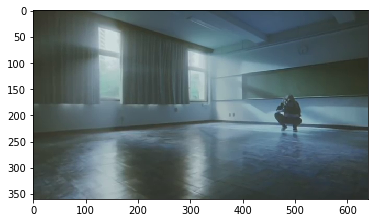

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the extracted frame.
f = plt.imshow(rgb)

In [5]:
# The embeddings generated by the pre-trained Inception model on the above frame.
print(features.shape)
print(features)

(1024,)
[ 1.289985    0.31538123  1.2575152  ... -1.0148749  -1.5626706
 -0.22029208]


### Using Google Cloud AI Platform 

We can package our model as a python module in a way compatible with `gcloud ai-platform`.
By using `gcloud ai-platform` as the interface we can easily launch the model training job on Google Cloud for large scale distributed training without any change of our code base.

The following code cells will write necessary python scripts as module, wrapping up all the codes in previous sections together.
Specifically, we need a `task.py` as the entrypoint for `gcloud ai-platform` to interface with our module.
If we'd like to use the hyper-parameter tuning service in Google Cloud, we need to make sure the hyper-parameters are part of the `task.py` command line arguments.
For this project for simplicity we are not going to do that.

In [6]:
%%bash
# Create python module directory.
mkdir -p src
touch src/__init__.py

In [7]:
%%writefile src/eval_metrics.py
"""Custom eval metrics for YouTube-8M model."""

import tensorflow as tf
from tensorflow.python.ops import init_ops


class AverageNClass(tf.keras.metrics.Metric):

    def __init__(self, name="average_n_class", **kwargs):
        super(tf.keras.metrics.Metric, self).__init__(name=name, **kwargs)
        self.n_example = self.add_weight(
            "n_example",
            shape=(),
            dtype=tf.float32,
            initializer=init_ops.zeros_initializer)
        self.n_predicted_class = self.add_weight(
            "n_predicted_class",
            shape=(),
            dtype=tf.float32,
            initializer=init_ops.zeros_initializer)

    def update_state(self, y_true, y_pred, **kwargs):
        # Accumulate sample size.
        batch_size = tf.cast(len(y_true), tf.float32)
        self.n_example.assign_add(batch_size)
        # Accumulate number of predicted classes.
        batch_n_class = tf.reduce_sum(tf.cast(y_pred > .5, tf.float32))
        self.n_predicted_class.assign_add(batch_n_class)

    def result(self):
        return self.n_predicted_class / self.n_example


class HitAtOne(tf.keras.metrics.Metric):

    def __init__(self, name="hit_at_one", **kwargs):
        super(tf.keras.metrics.Metric, self).__init__(name=name, **kwargs)
        self.n_example = self.add_weight(
            "n_example",
            shape=(),
            dtype=tf.float32,
            initializer=init_ops.zeros_initializer)
        self.hit_at_one = self.add_weight(
            "hit_at_one",
            shape=(),
            dtype=tf.float32,
            initializer=init_ops.zeros_initializer)

    def update_state(self, y_true, y_pred, **kwargs):
        # Accumulate sample size.
        batch_size = tf.cast(len(y_true), tf.float32)
        self.n_example.assign_add(batch_size)
        # Count number of hit@one.
        tops = tf.math.argmax(y_pred, axis=1, output_type=tf.int32)
        top_idx = tf.stack([tf.range(len(y_true)), tops], axis=1)
        hits = tf.gather_nd(y_true, indices=top_idx)
        self.hit_at_one.assign_add(tf.reduce_sum(hits))

    def result(self):
        return self.hit_at_one / self.n_example

Overwriting src/eval_metrics.py


In [8]:
%%writefile src/model.py
"""Video classification model on YouTube-8M dataset."""

import logging
from functools import partial

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import feature_column as fc
from tensorflow.python.ops import init_ops
from .eval_metrics import AverageNClass, HitAtOne


N_CLASS = 3862
BATCH_SIZE = 1024
VOCAB_FILE = "data/vocabulary.csv"
FEAT_COL_VIDEO = [
    fc.numeric_column(key="mean_rgb", shape=(1024,), dtype=tf.float32),
    #fc.numeric_column(key="mean_audio", shape=(128,), dtype=tf.float32),
    fc.indicator_column(fc.categorical_column_with_identity(key="labels", num_buckets=N_CLASS))
]
FEAT_X = ["mean_rgb"]
FEAT_SPEC_VIDEO = fc.make_parse_example_spec(FEAT_COL_VIDEO)
MULTI_HOT_ENCODER = tf.keras.layers.DenseFeatures(FEAT_COL_VIDEO[-1])


def calc_class_weight(infile, scale=1):
    """Calculate class weight to re-balance label distribution.
    The class weight for class i (w_i) is determined by:
    w_i = total no. samples / (n_class * count(class i))
    """
    vocab = pd.read_csv(infile).sort_values("Index")
    cnt = vocab["TrainVideoCount"]
    w = cnt.sum() / (len(vocab) * cnt)
    w = w.values.astype(np.float32)
    return pow(w, scale)


def _parse(examples, spec, batch_size, n_class):
    features = tf.io.parse_example(examples, features=spec)
    labels = features.pop("labels")
    labels = MULTI_HOT_ENCODER({"labels": labels})
    # Keras to estimator bug workaround.
    features["input_1"] = features.pop("mean_rgb")
    return features, labels


def input_fn(infiles, spec, mode=tf.estimator.ModeKeys.TRAIN):
    dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(infiles))
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=1000).repeat(count=None).batch(BATCH_SIZE, drop_remainder=True)
    else:
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
    dataset = dataset.map(partial(_parse, spec=spec, batch_size=BATCH_SIZE, n_class=N_CLASS))
    dataset = dataset.prefetch(BATCH_SIZE)
    return dataset


def serving_input_receiver_fn():
    """Parse seralized tfrecord string for online inference."""
    # Accept a list of serialized tfrecord string.
    example_bytestring = tf.compat.v1.placeholder(shape=[None], dtype=tf.string)
    # Parse them into feature tensors.
    features = tf.io.parse_example(example_bytestring, FEAT_SPEC_VIDEO)
    features.pop("labels")  # Dummy label. Not important at all.
    # Keras to estimator bug workaround.
    features["input_1"] = features.pop("mean_rgb")
    return tf.estimator.export.ServingInputReceiver(features, {"examples_bytes": example_bytestring})


class BaseModel:

    def __init__(self, params):
        self.params = params
        config = tf.estimator.RunConfig(
            tf_random_seed=777,
            save_checkpoints_steps=max(1000, params["train_steps"] // 10),
            model_dir=params["model_dir"]
        )
        self.class_weights = calc_class_weight(VOCAB_FILE, scale=1)
        self.serving_input_receiver_fn = serving_input_receiver_fn
        self.estimator = tf.keras.estimator.model_to_estimator(keras_model=self.model_fn(), config=config)

    def model_fn(self):

        def hamming_loss(y_true, y_pred):
            loss = tf.keras.backend.binary_crossentropy(y_true, y_pred, from_logits=False)
            if self.params["weighted_loss"]:
                loss *= self.class_weights
            return tf.reduce_mean(tf.reduce_sum(loss, axis=1))

        FEAT_COL_X = [col for col in FEAT_COL_VIDEO if col.name in FEAT_X]
        l2_reg = tf.keras.regularizers.l2(1e-8)
        fix = True  # Keras model to estimator bug workaround.
        if fix:
            inputs = tf.keras.layers.Input(shape=(1024,))
            predictions = tf.keras.layers.Dense(N_CLASS, acivation="sigmoid", kernel_regularizer=l2_reg)(inputs)
            model = tf.keras.Model(inputs=inputs, outputs=predictions)
        else :
            model = tf.keras.models.Sequential(name="baseline")
            model.add(tf.keras.layers.DenseFeatures(FEAT_COL_X))
            model.add(tf.keras.layers.Dense(N_CLASS, activation="sigmoid", kernel_regularizer=l2_reg))
        model.compile(
            optimizer="adam",
            loss=hamming_loss,
            metrics=[
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
                AverageNClass(),
                HitAtOne()
            ]
        )
        return model

    def train_and_evaluate(self, params):
        train_spec = tf.estimator.TrainSpec(
            input_fn=lambda: input_fn(params["train_data_path"], spec=FEAT_SPEC_VIDEO),
            max_steps=params["train_steps"]
        )
        exporter = tf.estimator.FinalExporter(
            name="exporter", serving_input_receiver_fn=serving_input_receiver_fn)
        eval_spec = tf.estimator.EvalSpec(
            input_fn=lambda: input_fn(params["eval_data_path"], spec=FEAT_SPEC_VIDEO,
                                      mode=tf.estimator.ModeKeys.EVAL),
            steps=100,
            start_delay_secs=60,
            throttle_secs=1,
            exporters=exporter
        )
        logging.getLogger("tensorflow").setLevel(logging.INFO)
        tf.estimator.train_and_evaluate(
            estimator=self.estimator,
            train_spec=train_spec,
            eval_spec=eval_spec
        )

Overwriting src/model.py


In [9]:
%%writefile src/task.py
"""Model interface for gcloud ai-platform."""

import argparse
import json
import os

from . import model

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--train_data_path",
        help="GCS or local path to training data",
        required = True
    )
    parser.add_argument(
        "--train_steps",
        help="Steps to run the training job for (default: 1000)",
        type=int,
        default=1000
    )
    parser.add_argument(
        "--eval_data_path",
        help="GCS or local path to evaluation data",
        required= True
    )
    parser.add_argument(
        "--model_dir",
        help="GCS location to write checkpoints and export models",
        required=True
    )
    parser.add_argument(
        "--weighted_loss",
        help = "Use class weights in loss?",
        required=False,
        default=True
    )
    parser.add_argument(
        "--job-dir",
        help="This is not used by our model, but it is required by gcloud",
    )
    args = parser.parse_args().__dict__

    # Append trial_id to path so trials don"t overwrite each other
    args["model_dir"] = os.path.join(
        args["model_dir"],
        json.loads(
            os.environ.get("TF_CONFIG", "{}")
        ).get("task", {}).get("trial", "")
    )

    # Run the training job
    yt8m_model = model.BaseModel(args)
    yt8m_model.train_and_evaluate(args)

Overwriting src/task.py


After we modualize our model, a local trainning job can be triggered by using `gcloud ai-platform` command line:
For example:

```bash
gcloud ai-platform local train \
    --package-path=src \
    --module-name=src.task \
    -- \
    --train_data_path=data/video/train* \
    --eval_data_path=data/video/valid* \
    --train_steps=30000 \
    --model_dir=local_debug_model
```

One thing to note is that the training speed is much slower than directly using Keras model API.
There seems to be a huge overhead after converting a Keras model to TF estimator.

To train the model on cloud, we can upload the training data to GCS then run instead something like:

```bash
gcloud ai-platform jobs submit training yt8m_$(date -u +%y%m%d_%H%M%S) \
    --package-path=src \
    --module-name=src.task \
    --job-dir=gs://${BUCKET}/yt8m \
    --python-version=3.5 \
    --runtime-version=${TFVERSION} \
    --region=us-central1 \
    -- \
    --train_data_path=gs://${BUCKET}/yt8m/data/video/train* \
    --eval_data_path=gs://${BUCKET}/yt8m/data/video/valid*  \
    --train_steps=30000 \
    --output_dir=gs://${BUCKET}/yt8m/models
```

The followings are tensorboard scalar tracing plots for our local training job.

Training Loss:

<img src="assets/train_loss.svg" align="left" width=480>

Eval Loss:

<img src="assets/eval_loss.svg" align="left" width=480>

Eval Precision:

<img src="assets/precision.svg" align="left" width=480>

Eval Recall:

<img src="assets/recall.svg" align="left" width=480>

Eval Hit@One:

<img src="assets/hit_at_one.svg" align="left" width=480>

Eval Average Number of Predicted Classes:

<img src="assets/average_n_class.svg" align="left" width=480>

### AI Platform Prediction Service

To deploy a pre-trained model we first need to upload the model directory to GCS.
This can be done by for example:

```bash
MODEL_DIR="local_debug_model"

gsutil -m rm -rf gs://${BUCKET}/yt8m/models
gsutil -m cp -r ${MODEL_DIR} gs://${BUCKET}/yt8m/models
```

Then to create a model for online prediction:

```bash
VERSION="v1"
TFVERSION="1.14"
MODEL_NAME="yt8m_video"
MODEL_DIR=local_debug_model

# Create ai-platform cloud model.
gcloud ai-platform models create ${MODEL_NAME} --regions us-central1

# Remove previous version.
gcloud ai-platform versions delete ${VERSION} --model ${MODEL_NAME} --quiet

# Deploy.
gcloud ai-platform versions create ${VERSION} --model ${MODEL_NAME} \
    --origin $(gsutil ls gs://${BUCKET}/yt8m/models/export/exporter | tail -1) \
    --python-version=3.5 \
    --runtime-version ${TFVERSION}
```

Note that as of now (July 2019) AI Platform runtime doesn't support TF 2.0 yet.
But our code is backward-compatible with 1.14.

## Online Prediction with a Wep App

We develop a web service using [Flask](https://palletsprojects.com/p/flask/) to receive user request about a YouTube video share link for online label(s) prediction.
Also we will use [socket.io](https://socket.io/) to implement asynchronous processing to improve user experience. (It takes time to process a raw video without using a dedicated server.)
Also we will use [youtube-dl](https://github.com/ytdl-org/youtube-dl) as the YouTube video downloader to download the requested video in `.mp4` format.
For video feature extraction we directly utilize the open source [starter code](https://github.com/google/youtube-8m/tree/master/feature_extractor) from Google Research.

The overall architecture of our application will look like this:

<img src="assets/app_arch_demo.svg">

To simplify things (in a one-week window) the web server is also doing video feature extraction which is a heavy task since it involves in loading a pre-trained Inception model and making inference through the graph.

The ideal architecture should be something like:

<img src="assets/app_arch_ideal.svg">

In [10]:
%%bash
# Create directories for our flask app.
mkdir -p app
mkdir -p app/templates
mkdir -p app/static
mkdir -p app/assets

### Server-Side Coding

The web server needs to do a series of task given a user request:

1. Download the requested video
2. Process the video to extract features in tfrecord
3. Parse the tfrecord back and package it in base64, send it to the online predictor
4. Receive prediction result and tidy it up, then send it to the front-end

Ideally we should by-pass the writing of tfrecord and direectly package the serialized string in-memory.
But since we utilize the starter code in feature extractor without changing anything, this is the extra effort needed to be done.

Here is the main script for the server:

In [11]:
%%writefile app/main.py
"""Run Flask app for YouTube-8M model demo."""

import os
import sys
import shutil
import tempfile
import subprocess
import base64

from flask import Flask, render_template, request
from flask_socketio import SocketIO, emit
import googleapiclient.discovery
import tensorflow as tf
import numpy as np


app = Flask(__name__)
socketio = SocketIO(app)

PROJECT = os.environ["PROJECT"]  # Name of gcloud project.
MODEL = "yt8m_video"  # Name of the deployed ai-platform model.
LABEL_VOCAB_FILE = "../data/vocabulary.csv"
VIDEO_DIR = "test_videos"
TFREC_DIR = "test_tfrecords"
YT_DL = "bin/youtube-dl"
FT_EXTRACTOR = "feature_extractor/extract_tfrecords_main.py"


def read_label_vocab(infile=LABEL_VOCAB_FILE):
    with open(infile, "rt") as f:
        raw_vocab = [l.strip("\n") for l in f.readlines()]
    header = raw_vocab[0].split(",")
    index_pos = header.index("Index")
    label_pos = header.index("Name")
    vocab = {}
    for line in raw_vocab[1:]:
        line = line.split(",")
        vocab[int(line[index_pos])] = line[label_pos]
    return vocab


def predict_json(instances, project=PROJECT, model=MODEL, version=None):
    # To authenticate set the environment variable
    # GOOGLE_APPLICATION_CREDENTIALS=<path_to_service_account_file>
    service = googleapiclient.discovery.build("ml", "v1")
    name = "projects/{}/models/{}".format(project, model)
    if version is not None:
        name += "/versions/{}".format(version)
    response = service.projects().predict(
        name=name,
        body={"instances": instances}
    ).execute()
    if "error" in response:
        raise RuntimeError(response["error"])
    return response["predictions"][0]


def parse_tfrecord(tfrec_file):
    """Encode tfrecord serialized string in base64."""
    rec_iter = tf.io.tf_record_iterator(tfrec_file)
    body = {"b64": base64.b64encode(next(rec_iter)).decode("utf-8")}
    return body


def video_to_tfrecord(video_file):
    video_tag = os.path.basename(video_file).split(".")[0]
    tmpcsv, tmpcsv_name = tempfile.mkstemp()
    tmprec, tmprec_name = tempfile.mkstemp()
    with open(tmpcsv_name, "wt") as f:
        f.write("{},0\n".format(video_file))
    p = subprocess.Popen([
        "python", FT_EXTRACTOR,
        "--input_videos_csv", tmpcsv_name,
        "--output_tfrecords_file", tmprec_name,
        "--skip_frame_level_features", "false"
        ], stdout=sys.stdout)    
    out, err = p.communicate()
    return tmprec_name


def download_yt(video_link, outdir=VIDEO_DIR):
    """Use youtube-dl to download a youtube video.
    https://github.com/ytdl-org/youtube-dl
    """
    video_tag = os.path.basename(video_link)
    outfile = os.path.join(outdir, "{}.mp4".format(video_tag))
    p = subprocess.Popen([
        YT_DL, video_link,
        "-o", outfile,
        "-k",
        "-f", "mp4"
        ], stdout=sys.stdout)    
    out, err = p.communicate()
    return outfile


def inspect_tfrec(tfrec_file, is_sequence=False):
    """Print a tfrecord file content."""
    record_iter = tf.io.tf_record_iterator(tfrec_file)
    if is_sequence:
        example = tf.train.SequenceExample()
        example.ParseFromString(next(record_iter))
    else:
        example = tf.train.Example()
        example.ParseFromString(next(record_iter))
    return example


vocab = read_label_vocab()


@socketio.on("predict_request", namespace="")
def start_predict_pipeline(message):
    # Form iframe to autoplay the requested youtube video.
    video_link = message["link"]
    video_tag = os.path.basename(video_link)
    emit("video_response", {"tag": video_tag})

    # Do prediction.
    # Check if the video is already processed before.
    tfrec_file = os.path.join(TFREC_DIR, "{}.tfrecord".format(video_tag))
    if not os.path.exists(tfrec_file):
        # Download the youtube video as mp4.
        emit("status_update", {"status": "Start Downloading video..."})
        video_file = download_yt(video_link)
        if os.path.exists(video_file):
            emit("status_update", {"status": "Download completed."})
        else:
            emit("status_update", {"status": "Invalid link!"})
            return
        # Convert mp4 to tfrecord.
        emit("status_update", {"status": "Extracting video embeddings..."})
        tmp_tfrec_file = video_to_tfrecord(video_file)
        shutil.move(tmp_tfrec_file, tfrec_file)
        emit("status_update", {"status": "Feature extraction completed."})
    # Request online prediction service.
    emit("status_update", {"status": "Request online predictions..."})
    request_data = parse_tfrecord(tfrec_file)
    responses = predict_json(request_data)
    emit("status_update", {"status": "All done!"})
    # Tidy predictions.
    predictions = {}
    proba = np.array(responses["activation"])
    top_k_pos = proba.argsort()[-10:][::-1]
    predictions["top_k"] = ["{}: {:.2%}".format(vocab[c], p) for c, p in 
        zip(top_k_pos, proba[top_k_pos])]
    predictions["n_class"] = str((proba > .5).sum())
    emit("predict_response", predictions)


@app.route("/", methods=["GET", "POST"])
def root():
    return render_template("index.html")


if __name__ == "__main__":
    # This is used when running locally only. When deploying to Google App
    # Engine, a webserver process such as Gunicorn will serve the app. This
    # can be configured by adding an `entrypoint` to app.yaml.
    socketio.run(app,host="0.0.0.0", port=8080, debug=True)

Overwriting app/main.py


### Client-Side Coding

For the front-end we need to write some simple `jquery` to handle the asynchronous calls made by `socket.io`.
We will update the page right-hand sidebar on each background task to inform the user what's going on.
For a new video the processing time can easily exceed 1 minute which is definitely too long.
If there is no response at the page a user may feel frustrated and just go away.

The file `app/templates/index.html` is created as the following:

Finally, this is how the app looks like after a prediction:

<img src="assets/demo.png">

It can handle virtually *any* public YouTube video.
Its a pity that the label *Samurai Shodown* didn't come at the top, since the game in play is indeed *Samurai Shodown*. But it is a brand-new released series title just a month ago as this writeup, so definitely we don't have any video about it in our training dataset.

## Final Thoughts

TensorFlow is evolving very fast.
There are a variety of ways in both training and deploying a machine learning model using TF.
Currently there is really lacking a sort of developing best-practice in this field, due to the constant changing in its API design.

Some definitely directions to move forward, particularly for Keras integration:

+ Better inter-operation between Keras model and TF estimator
    + Right now the process is really buggy
+ Better cloud prediction service deployment with Keras model
+ A more unified (hence less confused) framework for model saving and prediction pipeline